# Project 2 - Classification and regression using Neural Networks

This notebook contains the code which produces all results for the Project 2 report in FYS-STK4155.

*Fall 2025*

**Authors:** Jenny Guldvog, Ingvild Olden Bjerklund, Sverre Manu Johansen & Kjersti Stangeland

- 1500 datapoints
- 0.01 learning ratest
- 20   batch size
- 300 epochs
- beta1 og beta2
- sjekk Kjersti test train split

In [1]:
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
import time
import autograd.numpy as np
import numpy as np
from autograd import grad, elementwise_grad
from typing import Tuple, List
import seaborn as sns
import pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions import *

%load_ext autoreload
%autoreload 2

In [2]:
# For plotting

import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

# plt.rcParams.update({
#     'font.size': 16,          
#     'axes.titlesize': 18,     
#     'axes.labelsize': 16,   
#     'xtick.labelsize': 14,  
#     'ytick.labelsize': 14,
#     'legend.fontsize': 14,    
#     'figure.titlesize': 20,   
# })

#plt.rcParams['figure.figsize'] = (8, 6)

sns.set_context("notebook", font_scale=1.3)
sns.set_style("whitegrid")

In [3]:
# Scikit-Learn :
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
# Tensorflow-Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam     # NB! Remember this definition !!
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2      # NB! Remember this definition !!

In [5]:
# PyTorch : 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [6]:
# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
tf.random.set_seed(42)

In [7]:
n = 1500
x = np.linspace(-1, 1, n)
x = x.reshape(-1, 1)

y = runge_function(x) + np.random.normal(0, 0.1, (n,1))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) #/ X_std
X_test_norm  = (X_test - X_mean) #/ X_std

In [8]:
# All data used :
#inputs  = x
#targets = y
# Split into test and train :
inputs  = X_train_norm
targets = y_train
# Optionally add validationsplit :
# inputs  = ...
# targets = ...

x_test  = X_test_norm
y_test  = y_test

In [9]:
reg_nn_adam1    = NeuralNetwork(1, [10, 10, 1], [sigmoid, sigmoid, identity], [derivate(sigmoid), derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_RMSProp1 = NeuralNetwork(1, [10, 10, 1], [sigmoid, sigmoid, identity], [derivate(sigmoid), derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_gd1      = NeuralNetwork(1, [10, 10, 1], [sigmoid, sigmoid, identity], [derivate(sigmoid), derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_adam2    = NeuralNetwork(1, [10, 10, 1], [sigmoid, sigmoid, identity], [derivate(sigmoid), derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_RMSProp2 = NeuralNetwork(1, [10, 10, 1], [sigmoid, sigmoid, identity], [derivate(sigmoid), derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_gd2      = NeuralNetwork(1, [10, 10, 1], [sigmoid, sigmoid, identity], [derivate(sigmoid), derivate(sigmoid), derivate(identity)], mse, mse_der)

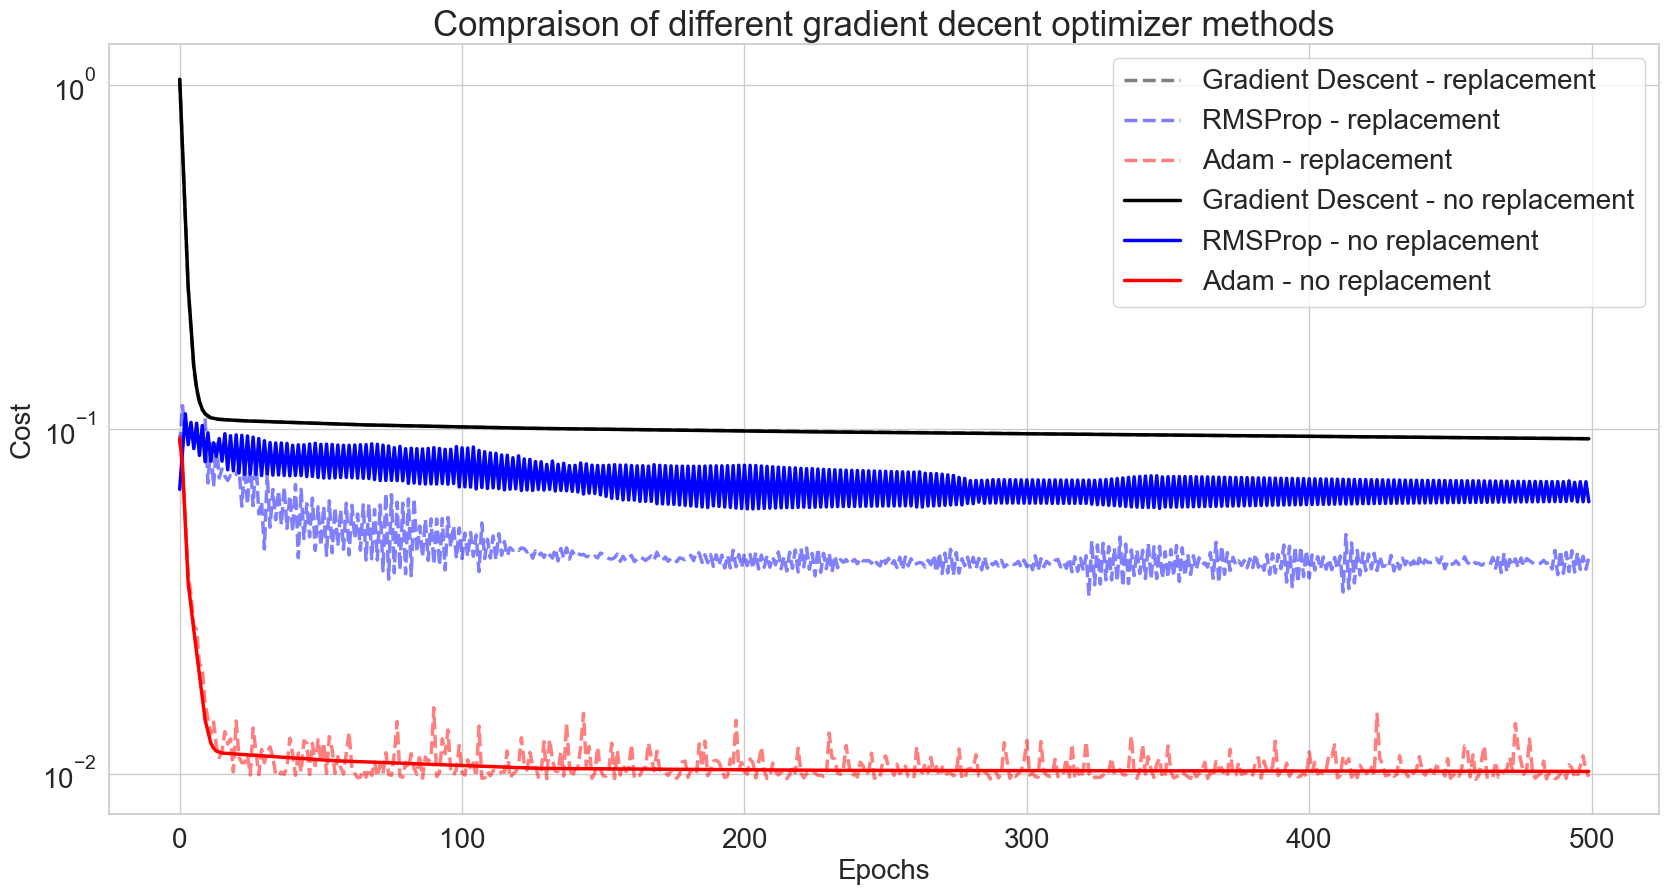

In [10]:
reg_nn_adam1.train_SGD(inputs, targets,    epochs=500, learning_rate=0.01, batch_size=16, optimizer="Adam")
reg_nn_RMSProp1.train_SGD(inputs, targets, epochs=500, learning_rate=0.01, batch_size=16, optimizer="RMSProp")
reg_nn_gd1.train_SGD(inputs, targets,      epochs=500, learning_rate=0.01, batch_size=16)
reg_nn_adam2.train_SGD_v2(inputs, targets,    epochs=500, learning_rate=0.01, batch_size=16, optimizer="Adam",    shuffle=False, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=False)
reg_nn_RMSProp2.train_SGD_v2(inputs, targets, epochs=500, learning_rate=0.01, batch_size=16, optimizer="RMSProp", shuffle=False, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=False)
reg_nn_gd2.train_SGD_v2(inputs, targets,      epochs=500, learning_rate=0.01, batch_size=16, optimizer='gd',      shuffle=False, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=False)


plt.figure(figsize=(20,10))
plt.plot(reg_nn_gd1.training_info["Cost_history"],      c='k', alpha=0.5, linewidth=2.5, linestyle='--', label="Gradient Descent - replacement")
plt.plot(reg_nn_RMSProp1.training_info["Cost_history"], c='b', alpha=0.5, linewidth=2.5, linestyle='--', label="RMSProp - replacement")
plt.plot(reg_nn_adam1.training_info["Cost_history"],    c='r', alpha=0.5, linewidth=2.5, linestyle='--', label="Adam - replacement")
plt.plot(reg_nn_gd2.training_info["Cost_history"],      c='k', linewidth=2.5, linestyle='-', label="Gradient Descent - no replacement")
plt.plot(reg_nn_RMSProp2.training_info["Cost_history"], c='b', linewidth=2.5, linestyle='-', label="RMSProp - no replacement")
plt.plot(reg_nn_adam2.training_info["Cost_history"],    c='r', linewidth=2.5, linestyle='-', label="Adam - no replacement")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.yscale("log")
plt.title("Compraison of different gradient decent optimizer methods", fontsize=25)
plt.legend(fontsize=20)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=20)  # Adjust font size here
plt.show()

In [11]:
reg_nn_adam1    = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_RMSProp1 = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_gd1      = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_adam2    = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_RMSProp2 = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_gd2      = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)

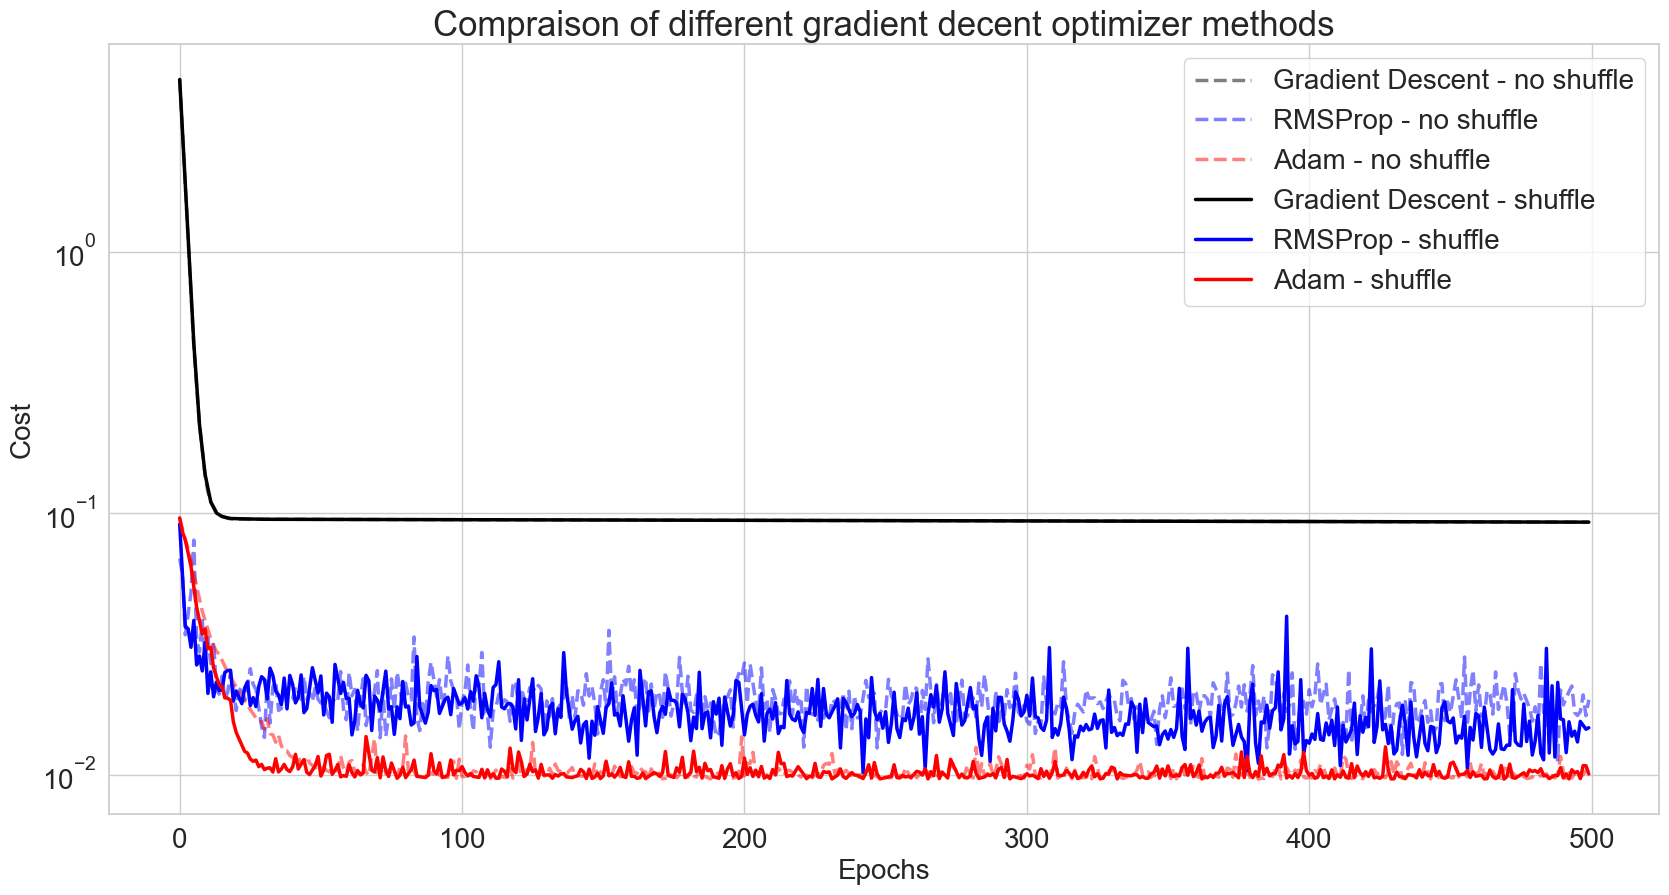

In [12]:
reg_nn_adam1.train_SGD(inputs, targets,    epochs=500, learning_rate=0.01, batch_size=16, optimizer="Adam")
reg_nn_RMSProp1.train_SGD(inputs, targets, epochs=500, learning_rate=0.01, batch_size=16, optimizer="RMSProp")
reg_nn_gd1.train_SGD(inputs, targets,      epochs=500, learning_rate=0.01, batch_size=16)
reg_nn_adam2.train_SGD_v2(inputs, targets,    epochs=500, learning_rate=0.01, batch_size=16, optimizer="Adam",    shuffle=True, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=True)
reg_nn_RMSProp2.train_SGD_v2(inputs, targets, epochs=500, learning_rate=0.01, batch_size=16, optimizer="RMSProp", shuffle=True, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=True)
reg_nn_gd2.train_SGD_v2(inputs, targets,      epochs=500, learning_rate=0.01, batch_size=16, optimizer='gd',      shuffle=True, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=True)


plt.figure(figsize=(20,10))
plt.plot(reg_nn_gd1.training_info["Cost_history"],      c='k', alpha=0.5, linewidth=2.5, linestyle='--', label="Gradient Descent - no shuffle")
plt.plot(reg_nn_RMSProp1.training_info["Cost_history"], c='b', alpha=0.5, linewidth=2.5, linestyle='--', label="RMSProp - no shuffle")
plt.plot(reg_nn_adam1.training_info["Cost_history"],    c='r', alpha=0.5, linewidth=2.5, linestyle='--', label="Adam - no shuffle")
plt.plot(reg_nn_gd2.training_info["Cost_history"],      c='k', linewidth=2.5, linestyle='-', label="Gradient Descent - shuffle")
plt.plot(reg_nn_RMSProp2.training_info["Cost_history"], c='b', linewidth=2.5, linestyle='-', label="RMSProp - shuffle")
plt.plot(reg_nn_adam2.training_info["Cost_history"],    c='r', linewidth=2.5, linestyle='-', label="Adam - shuffle")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.yscale("log")
plt.title("Compraison of different gradient decent optimizer methods", fontsize=25)
plt.legend(fontsize=20)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=20)  # Adjust font size here
plt.show()

In [13]:
reg_nn_adam1    = NeuralNetwork(1, [10, 10, 1], [RELU, RELU, identity], [derivate(RELU), derivate(RELU), derivate(identity)], mse, mse_der)
reg_nn_RMSProp1 = NeuralNetwork(1, [10, 10, 1], [RELU, RELU, identity], [derivate(RELU), derivate(RELU), derivate(identity)], mse, mse_der)
reg_nn_gd1      = NeuralNetwork(1, [10, 10, 1], [RELU, RELU, identity], [derivate(RELU), derivate(RELU), derivate(identity)], mse, mse_der)
reg_nn_adam2    = NeuralNetwork(1, [10, 10, 1], [RELU, RELU, identity], [derivate(RELU), derivate(RELU), derivate(identity)], mse, mse_der)
reg_nn_RMSProp2 = NeuralNetwork(1, [10, 10, 1], [RELU, RELU, identity], [derivate(RELU), derivate(RELU), derivate(identity)], mse, mse_der)
reg_nn_gd2      = NeuralNetwork(1, [10, 10, 1], [RELU, RELU, identity], [derivate(RELU), derivate(RELU), derivate(identity)], mse, mse_der)

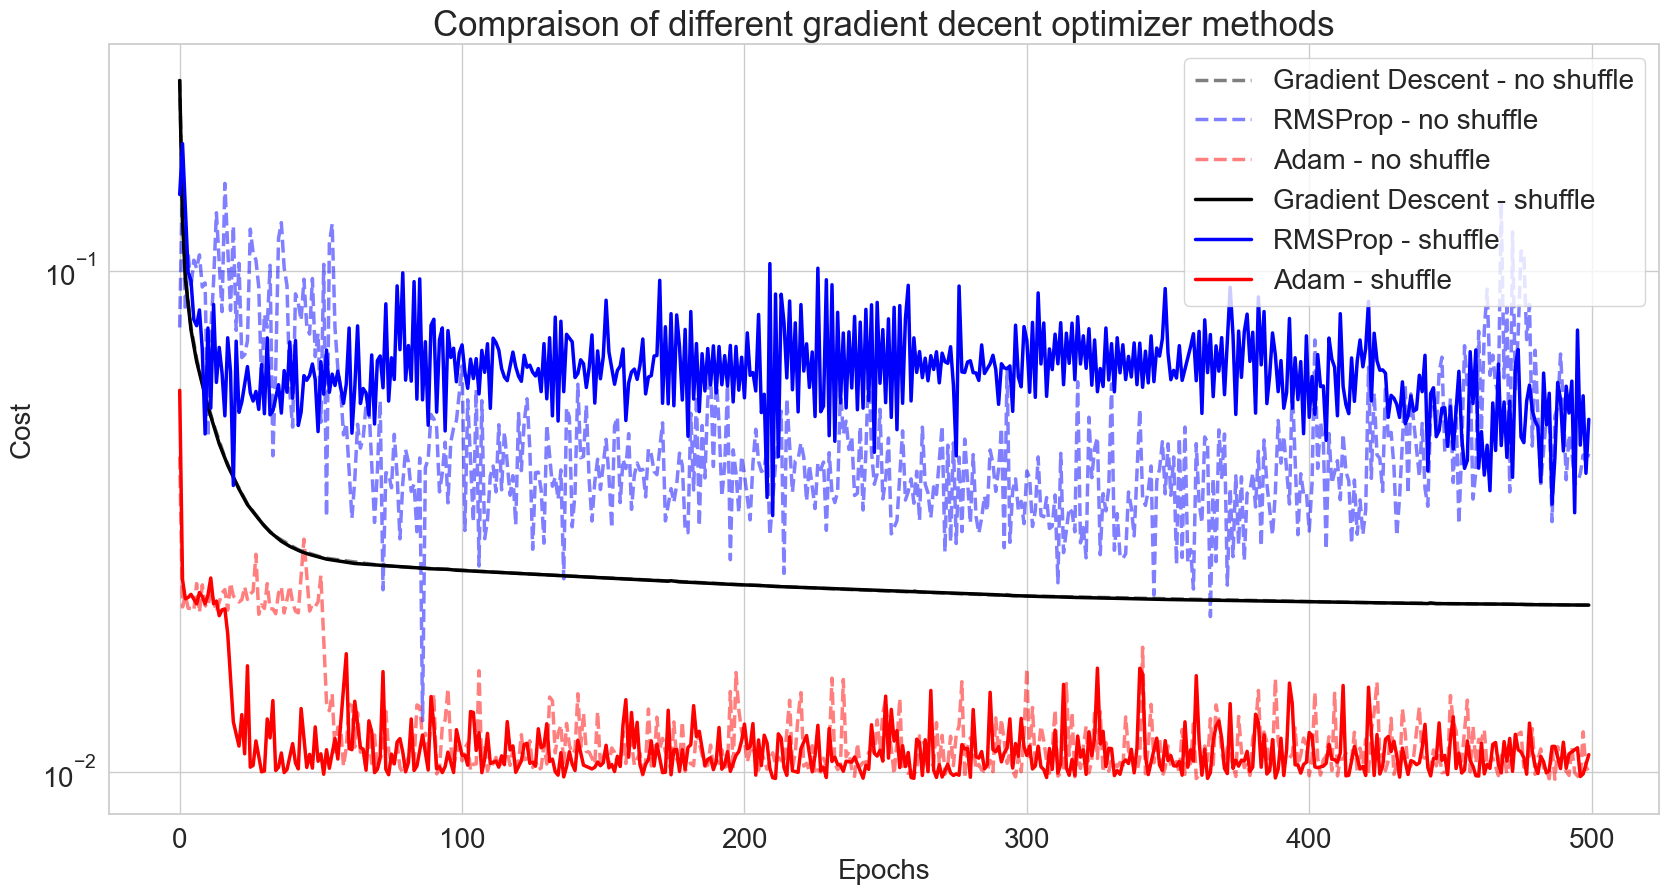

In [14]:
reg_nn_adam1.train_SGD(inputs, targets,    epochs=500, learning_rate=0.01, batch_size=16, optimizer="Adam")
reg_nn_RMSProp1.train_SGD(inputs, targets, epochs=500, learning_rate=0.01, batch_size=16, optimizer="RMSProp")
reg_nn_gd1.train_SGD(inputs, targets,      epochs=500, learning_rate=0.01, batch_size=16)
reg_nn_adam2.train_SGD_v2(inputs, targets,    epochs=500, learning_rate=0.01, batch_size=16, optimizer="Adam",    shuffle=True, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=True)
reg_nn_RMSProp2.train_SGD_v2(inputs, targets, epochs=500, learning_rate=0.01, batch_size=16, optimizer="RMSProp", shuffle=True, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=True)
reg_nn_gd2.train_SGD_v2(inputs, targets,      epochs=500, learning_rate=0.01, batch_size=16, optimizer='gd',      shuffle=True, beta1=0.9, beta2=0.99,  early_stopping=False, tolerance=1e-15, replace=True)


plt.figure(figsize=(20,10))
plt.plot(reg_nn_gd1.training_info["Cost_history"],      c='k', alpha=0.5, linewidth=2.5, linestyle='--', label="Gradient Descent - no shuffle")
plt.plot(reg_nn_RMSProp1.training_info["Cost_history"], c='b', alpha=0.5, linewidth=2.5, linestyle='--', label="RMSProp - no shuffle")
plt.plot(reg_nn_adam1.training_info["Cost_history"],    c='r', alpha=0.5, linewidth=2.5, linestyle='--', label="Adam - no shuffle")
plt.plot(reg_nn_gd2.training_info["Cost_history"],      c='k', linewidth=2.5, linestyle='-', label="Gradient Descent - shuffle")
plt.plot(reg_nn_RMSProp2.training_info["Cost_history"], c='b', linewidth=2.5, linestyle='-', label="RMSProp - shuffle")
plt.plot(reg_nn_adam2.training_info["Cost_history"],    c='r', linewidth=2.5, linestyle='-', label="Adam - shuffle")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.yscale("log")
plt.title("Compraison of different gradient decent optimizer methods", fontsize=25)
plt.legend(fontsize=20)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=20)  # Adjust font size here
plt.show()

## Part c) Testing agains other software libraries

##### 1) Test against Scikit-Learn, tensorflow.keras or PyTorch

You should test your results against a similar code using **Scikit-Learn** (see the examples in the above lecture notes from weeks 41 and 42) or **tensorflow/keras** or **Pytorch** (for Pytorch, see Raschka et al.'s text chapters 12 and 13). 

In [15]:
# Define hyperparameters:
network_input_size          = 1
seed                        = None       # Determines random number generation for weights and bias initialization?
learning_rate               = 0.01       # The initial learning rate used. It controls the step-size in updating the weights. 
epochs                      = 300#1000       # Number of total iterations.
batch_size                  = 20#16         # Size of minibatches for stochastic optimizers.
shuffle                     = True       # Whether to shuffle samples in each iteration.
early_stopping              = False      # Whether to use early stopping to terminate training when validation score is not improving.
tolerance                   = 1e-15      # Tolerance for the optimization. When the loss or score is not improving by at least tol
replacement                 = False      # Create batches with replacement or not in SGD
beta_1                      = 0.9        # ADAM: Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1).
beta_2                      = 0.999      # ADAM: Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1).
# Scikit-learn specific:
scikit_lr_type              = 'adaptive' # 'constant', 'adaptive' or 'invscaling'
scikit_alpha                = 0          # L2 regularization term
scikit_verbose              = False      # Whether to print progress messages to stdout.
scikit_warm_start           = False      # When set to True, reuse the solution of the previous call to fit as initialization, otherwise, 
                                         # just erase the previous solution. 
scikit_momentum             = 0.9        # Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.
scikit_nesterovs_momentum   = False      # Whether to use Nesterov’s momentum. Only used when solver=’sgd’ and momentum > 0.
scikit_validation_fraction  = 0          # The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. 
                                         # Only used if early_stopping is True.
scikit_epsilon              = 1e-8       # Value for numerical stability in adam. Only used when solver=’adam’.
scikit_n_iter_no_change     = epochs     # Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.
                                         # For it to run until the end, keep this as big as the epochs !
# Keras specific:
keras_verbose               = 0          # Whether to print progress messages to stdout. 1 is print

In [16]:
# Network arcitecture:
FFNN_layers   = [8, 1] # The last element is the outputlayer ?
scikit_layer  = (8, 1)   # The ith element represents the number of neurons in the ith hidden layer.
keras_layers  = [8, 1] # The last element is the outputlayer.
torch_layers1 = nn.Linear(1, 8)   # Input layer to hidden layer
torch_layers2 = nn.Linear(8, 1)   # Hidden layer to output layer

# Cost function:
FFNN_cost_fun     = mse
FFNN_cost_fun_der = mse_der
keras_cost_fun    = 'mean_squared_error'

# Activation functions:
FFNN_act_fun     = [sigmoid, sigmoid]
FFNN_act_fun_der = [derivate(sigmoid), derivate(sigmoid)]
scikit_act_fun   = 'logistic' # 'identity', 'logistic', tanh', 'relu' --> NB! No option for sigmoid, but logistic should be the same?
keras_act_fun    = ['sigmoid', 'sigmoid'] # ['sigmoid', 'linear']
#torch_act_fun1   = torch.sigmoid(self.hidden(x))   # Sigmoid activation function for hidden layer
#torch_act_fun2   = self.output(x)                  # Linear activation for output layer

# Solver/optimizer:
FFN_solver    = 'Adam'
scikit_solver = 'adam' #'adam', 'sgd', 
keras_solver  = Adam(learning_rate = learning_rate, 
                     beta_1        = beta_1, 
                     beta_2        = beta_2, 
                     epsilon       = scikit_epsilon) # SGD(learning_rate=learning_rate)

In [17]:
# Initialize the network, so that the weights are not remembered
Regression_FFNN = NeuralNetwork(network_input_size,
                                FFNN_layers, 
                                FFNN_act_fun, 
                                FFNN_act_fun_der, 
                                FFNN_cost_fun, 
                                FFNN_cost_fun_der)
# Start the timer
start_time = time.time()
# Train the model
#Regression_FFNN.train_SGD(inputs, targets, 
#                          learning_rate = learning_rate, 
#                          epochs        = epochs,  
#                          batch_size    = batch_size, 
#                          optimizer     = FFN_solver)
Regression_FFNN.train_SGD_v2(inputs, targets,
                             epochs         = epochs, 
                             learning_rate  = learning_rate, 
                             batch_size     = batch_size, 
                             optimizer      = FFN_solver,    
                             shuffle        = shuffle, 
                             beta1          = beta_1, 
                             beta2          = beta_2,  
                             early_stopping = early_stopping, 
                             tolerance      = tolerance, 
                             replace        = replacement)
# Make predictions
y_pred = Regression_FFNN._feed_forward(x_test)
# Calculate mean squared error
mse_proj2  = mse(y_test, y_pred)
mse_proj22 = mean_squared_error(y_test, y_pred)
# Calculate elapsed time
elapsed_time_FFNN = time.time() - start_time
# Print results
print(f"Project-2 MSE: {mse_proj2}")
print(f"Project-2 MSE: {mse_proj22}")
print(f"Elapsed time: {elapsed_time_FFNN:.2f} seconds")

Project-2 MSE: 0.010484824427317692
Project-2 MSE: 0.010484824427317692
Elapsed time: 6.80 seconds


In [18]:
# Start the timer
start_time = time.time()
# Create and train the Scikit-Learn model --> Multi-layer Perceptron regressor : 
sklearn_model = MLPRegressor(#loss='squared_error', 
                            hidden_layer_sizes  = scikit_layer, 
                            activation          = scikit_act_fun,
                            solver              = scikit_solver,
                            alpha               = scikit_alpha,
                            batch_size          = batch_size,
                            learning_rate       = scikit_lr_type,
                            learning_rate_init  = learning_rate, 
                            # power_t=0.5, # The exponent for inverse scaling learning rate. 
                            # It is used in updating effective learning rate when the learning_rate is set to ‘invscaling’. Only used when solver=’sgd’.
                            max_iter            = epochs, 
                            shuffle             = shuffle, 
                            random_state        = seed, 
                            tol                 = tolerance, 
                            verbose             = scikit_verbose,
                            warm_start          = scikit_warm_start,
                            momentum            = scikit_momentum,
                            nesterovs_momentum  = scikit_nesterovs_momentum,
                            early_stopping      = early_stopping,
                            validation_fraction = scikit_validation_fraction,
                            beta_1              = beta_1,
                            beta_2              = beta_2,
                            epsilon             = scikit_epsilon,
                            n_iter_no_change    = scikit_n_iter_no_change,
                            # max_fun=15000, # Only used when solver=’lbfgs’. 
                            )
sklearn_model.fit(inputs, targets.ravel())
# Predictions
y_pred_sklearn = sklearn_model.predict(x_test)
# Calculate mean squared error
mse_sklearn  = mse(y_test.flatten(), y_pred_sklearn)
mse_sklearn2 = mean_squared_error(y_test, y_pred_sklearn)
# Calculate elapsed time
elapsed_time_scikit = time.time() - start_time
print(f"Scikit-Learn MSE: {mse_sklearn}")
print(f"Scikit-Learn MSE: {mse_sklearn2}")
print(f"Elapsed time: {elapsed_time_scikit:.2f} seconds")

Scikit-Learn MSE: 0.07297360717426787
Scikit-Learn MSE: 0.07297360717426787
Elapsed time: 7.30 seconds


c:\Users\Ingvild\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
# Signs of overfitting?
train_loss = sklearn_model.loss_curve_
final_train_loss = train_loss[-1]  # Get last loss in curve
mse_calculated = mean_squared_error(y_test, y_pred_sklearn) 
print(f"Final training loss (from curve): {final_train_loss}")
print(f"Calculated MSE from test data: {mse_calculated}")

Final training loss (from curve): 0.037649781423867615
Calculated MSE from test data: 0.07297360717426787


In [20]:
# Create a simple feedforward neural network using Keras
model = Sequential()
model.add(Dense(keras_layers[0], activation=keras_act_fun[0], input_dim=network_input_size))  # 1 input, 8 hidden neurons
model.add(Dense(keras_layers[1], activation=keras_act_fun[1]))                                # Output layer
# Regularization options : 
#model.add(Dense(keras_layers[0], activation=keras_act_fun[0], input_dim=network_input_size, kernel_regularizer=l2(0.01)))  # 1 input, 8 hidden neurons
#model.add(Dense(keras_layers[1], activation=keras_act_fun[1], kernel_regularizer=l1(0.01))) 
# Compile the model with optimkeras_solverizer
model.compile(loss=keras_cost_fun, optimizer=keras_solver)
# Define the prediction function
@tf.function(reduce_retracing=True)
def predict_fn(x):
    return model(x)
# Start the timer
start_time = time.time()
# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', 
#                               patience=5, 
#                               min_delta=1e-4, 
#                               restore_best_weights=True)
# Train the model and capture the loss history
history = model.fit(inputs, targets, 
                    epochs     = epochs, 
                    batch_size = batch_size, 
                    verbose    = keras_verbose,
                    #validation_split = 0,
                    shuffle     = shuffle,
                    #callbacks  = [early_stopping]
                    )
# Predictions
#y_pred_keras = model.predict(x) # OLD
y_pred_keras = predict_fn(x_test).numpy()  # Convert from tensor to numpy
# Calculate mean squared error
mse_keras  = mse(y_test, y_pred_keras)
mse_keras2 = mean_squared_error(y_test, y_pred_keras)
# Calculate elapsed time
elapsed_time_keras = time.time() - start_time
print(f"Tensorflow-Keras MSE: {mse_keras}")
print(f"Tensorflow-Keras MSE: {mse_keras2}")
print(f"Elapsed time: {elapsed_time_keras:.2f} seconds")

c:\Users\Ingvild\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tensorflow-Keras MSE: 0.010469336786718353
Tensorflow-Keras MSE: 0.010469336786718353
Elapsed time: 49.54 seconds


In [21]:
# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define a simple feedforward neural network
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.hidden = torch_layers1
        self.output = torch_layers2
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))   # Sigmoid activation function for hidden layer
        x = self.output(x)                  # Linear activation for output layer
        return x
# Prepare data
x_tensor = torch.tensor(inputs, dtype=torch.float32).view(-1, 1).to(device)   # Reshape for PyTorch
y_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1).to(device)  # Reshape and send to device
# Create a TensorDataset and DataLoader
dataset     = TensorDataset(x_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)  # shuffle=True to shuffle the data
# Initialize the model, loss function and optimizer
#model     = FeedForwardNN()
model = FeedForwardNN().to(device)  # Move model to device
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Changed from SGD to Adam
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)  # L2 regularization with weight_decay
# Prepare for early stopping
#best_loss = float('inf')
#patience = 5  # Number of epochs with no improvement after which training will be stopped
#early_stopping_counter = 0
# Start the timer
start_time = time.time()
# List to store loss values
loss_history = []
# Training loop
for epoch in range(epochs):
    model.train()                        # Set model to training mode
    optimizer.zero_grad()                # Clear the gradients
    outputs = model(x_tensor)            # Forward pass
    loss = criterion(outputs, y_tensor)  # Calculate loss
    loss.backward()                      # Backward pass (gradient calculation)
    optimizer.step()                     # Update weights
    # Store loss for plotting
    loss_history.append(loss.item())
    # Early stopping logic
    #if (epoch + 1) % 10 == 0:  # Check for improvement every 10 epochs
        #model.eval()  # Set model to evaluation mode
        #with torch.no_grad():
            #val_loss = criterion(model(x_tensor), y_tensor).item()  # Calculate validation loss
        #if val_loss < best_loss - 1e-4:  # Check if the loss improved by at least the tolerance
            #best_loss = val_loss
            #early_stopping_counter = 0  # Reset counter
        #else:
            #early_stopping_counter += 1
        #if early_stopping_counter >= patience:  # Stop training early
            #print(f'Early stopping at epoch {epoch + 1}')
            #break
# Predictions
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).view(-1, 1).to(device)   # Reshape for PyTorch
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # disable gradient calculation for evaluation 
    y_pred_pytorch = model(x_test_tensor).cpu().numpy()  # Move tensor to CPU and convert to numpy
#y_pred_pytorch = model(x_tensor).detach().numpy()
# Calculate mean squared error
mse_pytorch  = mse(y_test, y_pred_pytorch)
mse_pytorch2 = mean_squared_error(y_test, y_pred_pytorch)
# Calculate elapsed time
elapsed_time_pytorch = time.time() - start_time
# Print results
print(f"PyTorch MSE: {mse_pytorch}")
print(f"PyTorch MSE: {mse_pytorch2}")
print(f"Elapsed time: {elapsed_time_pytorch:.2f} seconds")

PyTorch MSE: 0.0727902922049661
PyTorch MSE: 0.0727902922049661
Elapsed time: 0.48 seconds


In [22]:
# # Plotting the cost history
# plt.figure(figsize=(20,10))
# plt.plot(Regression_FFNN.get_info()["Cost_history"], c='k', linewidth=3.5, linestyle='-', label=f'FFNN, {elapsed_time_FFNN:.2f} sec, MSE:{mse_proj2:.4f}')
# plt.plot(sklearn_model.loss_curve_, c='g', linewidth=3.5, linestyle='-', label=f'Scikit-Learn, {elapsed_time_scikit:.2f} sec, MSE:{mse_sklearn:.4f}')
# plt.plot(history.history['loss'], c='b', linewidth=3.5, linestyle='-', label=f'Tensorflow-Keras, {elapsed_time_keras:.2f} sec, MSE:{mse_keras:.4f}')
# plt.plot(loss_history, c='r', linewidth=3.5, linestyle='-', label=f'PyTorch, {elapsed_time_pytorch:.2f} sec, MSE:{mse_pytorch:.4f}')
# plt.xlabel("Epochs", fontsize=20)
# plt.ylabel("Cost", fontsize=20)
# plt.yscale("log")
# plt.title("Comparing FFNN to Libraries with layers=[8,1], and optimizer=ADAM", fontsize=25)
# plt.legend(fontsize=20)
# # Increase tick label font size 
# plt.tick_params(axis='both', which='major', labelsize=20)  # Adjust font size here
# plt.show()

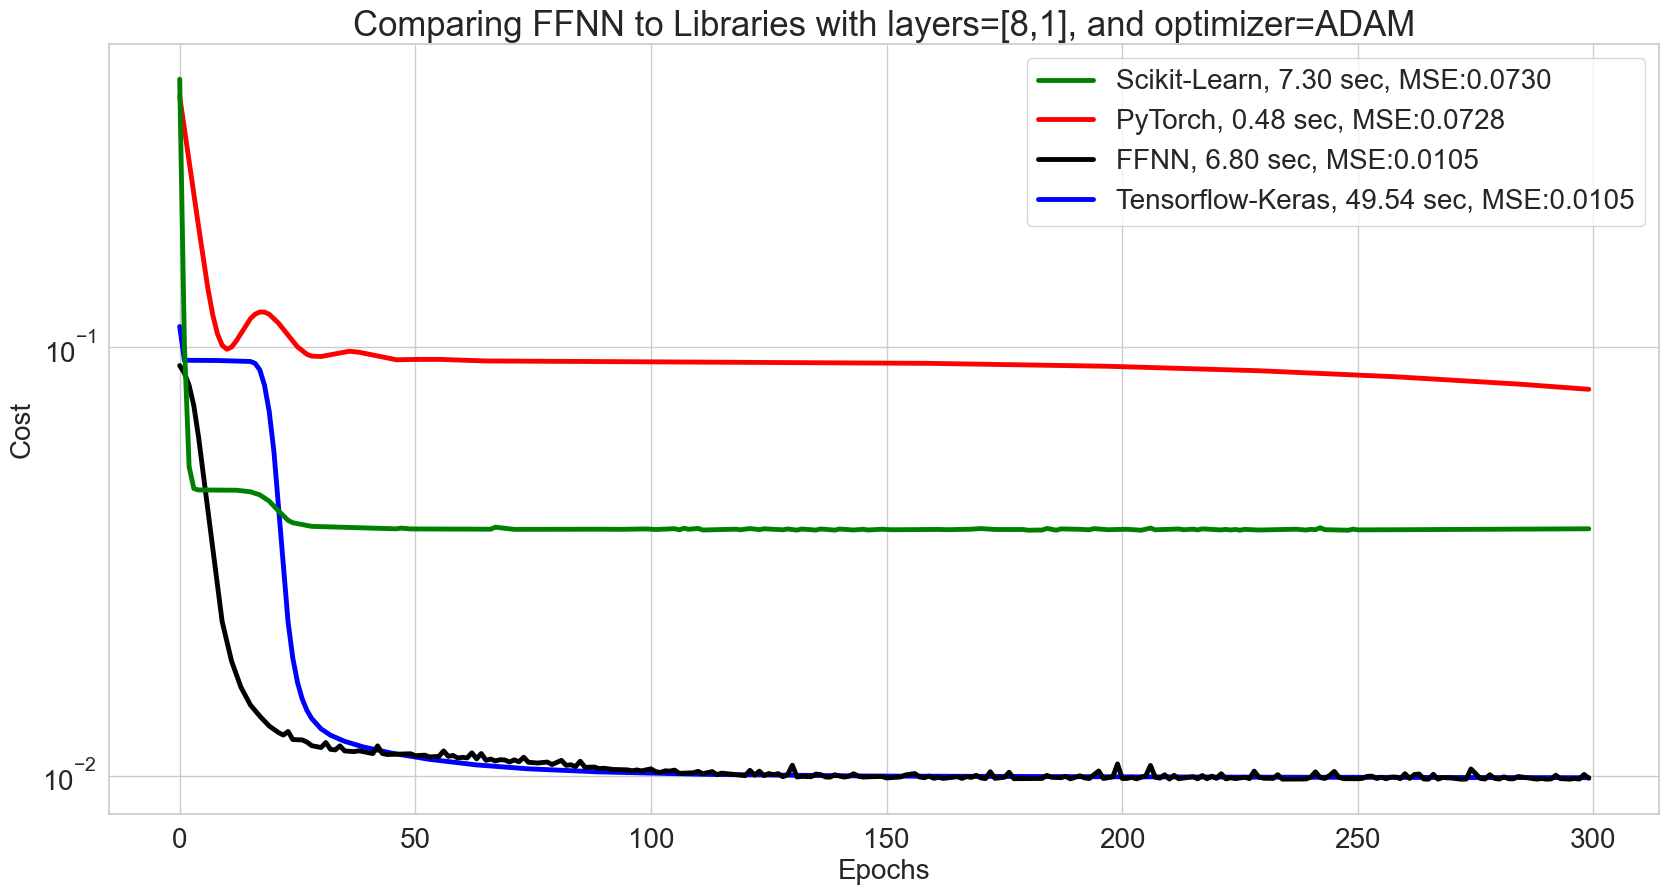

In [23]:
# Create a list of (MSE, plot data) tuples
plot_data = [
    (mse_proj2, (Regression_FFNN.get_info()["Cost_history"], 'k', 'FFNN', elapsed_time_FFNN)),
    (mse_sklearn, (sklearn_model.loss_curve_, 'g', 'Scikit-Learn', elapsed_time_scikit)),
    (mse_keras, (history.history['loss'], 'b', 'Tensorflow-Keras', elapsed_time_keras)),
    (mse_pytorch, (loss_history, 'r', 'PyTorch', elapsed_time_pytorch)),
]
# Sort the data by MSE in descending order
plot_data.sort(key=lambda x: x[0], reverse=True)
# Plot the data
plt.figure(figsize=(20,10))
for mse, (data, color, label, elapsed_time) in plot_data:
    plt.plot(data, c=color, linewidth=3.5, linestyle='-', 
             label=f'{label}, {elapsed_time:.2f} sec, MSE:{mse:.4f}', 
             zorder=mse * 1000)  # Use MSE for zorder
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.yscale("log")
plt.title("Comparing FFNN to Libraries with layers=[8,1], and optimizer=ADAM", fontsize=25)
plt.legend(fontsize=20)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

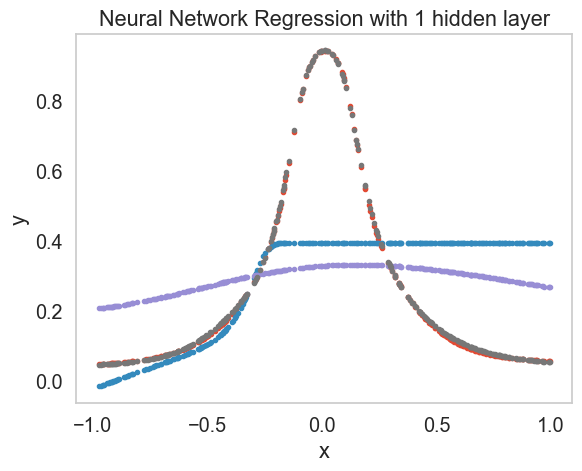

In [24]:
plt.plot(x_test, y_pred, ".", label="1 layer NN Prediction after 100000 epochs")
plt.plot(x_test, y_pred_sklearn, ".", label="2 layer NN Prediction after 100000 epochs")
plt.plot(x_test, y_pred_pytorch, ".", label="2 layer NN Prediction after 100000 epochs")
plt.plot(x_test, y_pred_keras, ".", label="2 layer NN Prediction after 100000 epochs")
#plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Neural Network Regression with 1 hidden layer")
plt.show()

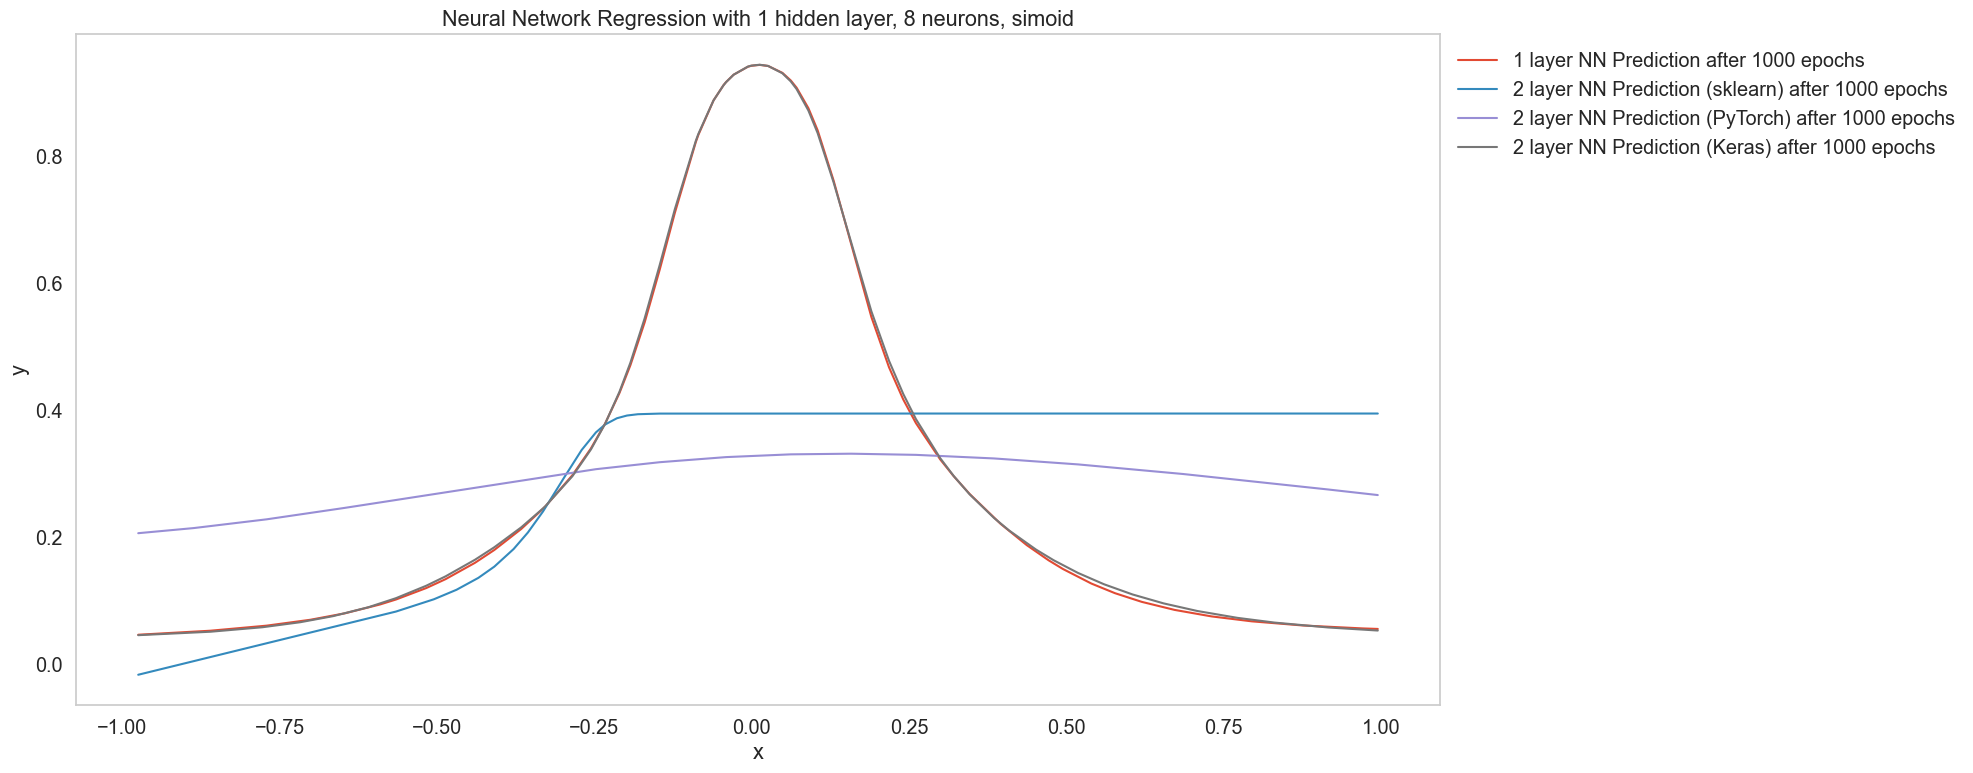

In [25]:
# Ensure x_test is a 1D array
x_test = x_test.flatten()  # Use .ravel() if you want to preserve a copy of the original array

# Sort the data
sorted_indices = np.argsort(x_test)
x_sorted = x_test[sorted_indices]

# Flatten y predictions to 1D
y_sorted = {
    "1 layer NN": y_pred[sorted_indices].flatten(),
    "2 layer NN (sklearn)": y_pred_sklearn[sorted_indices].flatten(),
    "2 layer NN (PyTorch)": y_pred_pytorch[sorted_indices].flatten(),
    "2 layer NN (Keras)": y_pred_keras[sorted_indices].flatten(),
}

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(x_sorted, y_sorted["1 layer NN"], "-", label="1 layer NN Prediction after 1000 epochs")
plt.plot(x_sorted, y_sorted["2 layer NN (sklearn)"], "-", label="2 layer NN Prediction (sklearn) after 1000 epochs")
plt.plot(x_sorted, y_sorted["2 layer NN (PyTorch)"], "-", label="2 layer NN Prediction (PyTorch) after 1000 epochs")
plt.plot(x_sorted, y_sorted["2 layer NN (Keras)"], "-", label="2 layer NN Prediction (Keras) after 1000 epochs")

plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Neural Network Regression with 1 hidden layer, 8 neurons, simoid")

# Move the legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()  # Adjust layout to accommodate legend
plt.show()


##### 2) Test against Autograd or 

Also test that your derivatives are correctly
calculated using automatic differentiation, using for example the
**Autograd** library or the **JAX** library. It is optional to implement
these libraries for the present project. In this project they serve as
useful tests of our derivatives.

In [26]:
import autograd.numpy as np
from autograd import grad

# Define the cost function for a one-layer neural network
def cost_one_layer(W, b, x, target):
    z = np.dot(W, x) + b
    a = 1.0 / (1 + np.exp(-z))  # Sigmoid activation
    return np.mean((a - target) ** 2)  # Mean squared error

# Mean Squared Error derivative
def mse_der(predict, target):
    target = target.reshape(-1)  # Ensure target is a 1D array
    assert predict.shape == target.shape, "Not same"
    return 2 * (predict - target) / target.size

# Sigmoid activation function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Derivative of sigmoid function
def sigmoid_der(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

# Random input and target for testing
x = np.random.rand(2)
target = np.random.rand(3)

# Random weights and bias
W = np.random.rand(3, 2)
b = np.random.rand(3)

# Calculate gradients using autograd
autograd_one_layer = grad(cost_one_layer, [0, 1])

# Compute the activations and predictions
z = W @ x + b
a = sigmoid(z)
predict = a

# Calculate the derivatives for backpropagation
dC_da = mse_der(predict.reshape(-1), target)  # Ensure same shape

da_dz = sigmoid_der(z)

dC_dz = dC_da * da_dz

dC_dW = np.outer(dC_dz, x)  # Gradient wrt weights

dC_db = dC_dz  # Gradient wrt biases

# Print the computed gradients and derivatives
print("\n--- Backpropagation Derivatives ---")
print(f"Weight Gradient (dC/dW):\n{dC_dW}\n")
print(f"Bias Gradient (dC/db):\n{dC_db}\n")

# Compute the gradients using autograd
W_g, b_g = autograd_one_layer(W, b, x, target)

# Print autograd gradients
print("--- Autograd Gradients ---")
print(f"Weight Gradient from Autograd (dC/dW):\n{W_g}\n")
print(f"Bias Gradient from Autograd (dC/db):\n{b_g}\n")

# Optional: compare the results to see if they're similar
print("--- Comparison of Gradients ---")
print(f"Difference in Weight Gradients:\n{W_g - dC_dW}\n")
print(f"Difference in Bias Gradients:\n{b_g - dC_db}\n")



--- Backpropagation Derivatives ---
Weight Gradient (dC/dW):
[[ 0.03383468  0.02253212]
 [ 0.00682551  0.00454543]
 [-0.01180601 -0.00786218]]

Bias Gradient (dC/db):
[ 0.06651741  0.01341864 -0.02321007]

--- Autograd Gradients ---
Weight Gradient from Autograd (dC/dW):
[[ 0.03383468  0.02253212]
 [ 0.00682551  0.00454543]
 [-0.01180601 -0.00786218]]

Bias Gradient from Autograd (dC/db):
[ 0.06651741  0.01341864 -0.02321007]

--- Comparison of Gradients ---
Difference in Weight Gradients:
[[ 6.93889390e-18  3.46944695e-18]
 [-3.46944695e-18 -2.60208521e-18]
 [ 1.73472348e-18  0.00000000e+00]]

Difference in Bias Gradients:
[ 1.38777878e-17 -6.93889390e-18  3.46944695e-18]



## Optional (at least two)


1. Implement **Logistic Regression as simple classification model case** (equivalent to a Neural Network with just the output layer)

2. Compute the gradient of the neural network with **autograd**, to show that it gives the same result as your **hand-written backpropagation**.

3. **Compare** your results with results from using a **machine-learning library** like pytorch (https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

4. Use a **more complex classification dataset** instead, like the fashion MNIST (see <https://www.kaggle.com/datasets/zalando-research/fashionmnist>)

5. Use a **more complex regression dataset** instead, like the two-dimensional Runge function $f(x,y)=\left[(10x - 5)^2 + (10y - 5)^2 + 1 \right]^{-1}$, or even more complicated two-dimensional functions (see the supplementary material of <https://www.nature.com/articles/s41467-025-61362-4> for an extensive list of two-dimensional functions). 

6. **Compute and interpret a confusion matrix of your best classification model** (see <https://www.researchgate.net/figure/Confusion-matrix-of-MNIST-and-F-MNIST-embeddings_fig5_349758607>)